## Instalação de dependencias

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sklearn.naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Funções auxiliares

In [5]:
def mapear_outliers(df):
    """
    Calcula os limites inferior e superior de outliers usando IQR,
    bem como a contagem e os índices desses outliers para cada coluna.

    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.

    Retorno:
    dict: Dicionário no formato {'coluna': {upr_bound, lwr_bound, outlier_idx, outlier_count}}
    """
    resultados_outliers = {}
    colunas_numericas = df.select_dtypes(include=['number']).columns.tolist()

    for col in colunas_numericas:
        # Calcula os quartis e o IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        iqr = Q3 - Q1

        # Calcula os limites (bounds)
        UPR = Q3 + iqr * 1.5
        LOW = Q1 - iqr * 1.5

        # Isola as linhas que são consideradas outliers
        outliers = df[(df[col] < LOW) | (df[col] > UPR)]

        # Extrai a contagem e os índices (convertidos para lista para facilitar o uso)
        outlier_count = len(outliers)
        outlier_idx = outliers.index.tolist()

        # Adiciona o objeto ao dicionário de resultados
        resultados_outliers[col] = {
            'upr_bound': UPR,
            'lwr_bound': LOW,
            'outlier_idx': outlier_idx,
            'outlier_count': outlier_count
        }

    return resultados_outliers

## Carregando Datasets

In [6]:
df = pd.read_csv('data/reddit_dead_internet_analysis_2026.csv', sep=',', encoding='utf-8')

## Análise Exploratória de Dados (EDA)

In [7]:
display(df.head())
display(df.info())

,comment_id,subreddit,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,contains_links,is_bot_flag,bot_type_label,bot_probability
0,t1_3148938807,funny,2264,34192,1854,-0.60,4.62,False,False,None (Human),0.093
1,t1_2516748923,gaming,1654,2812,1033,0.15,5.84,False,False,None (Human),0.117
2,t1_833922318,politics,2442,37109,2703,0.35,5.73,False,False,None (Human),0.115
3,t1_3987809057,funny,168,32997,2811,-0.74,4.58,False,False,None (Human),0.094
4,t1_3931039688,gaming,801,25088,1721,-0.96,5.78,False,False,None (Human),0.116


<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_id           500 non-null    str    
 1   subreddit            500 non-null    str    
 2   account_age_days     500 non-null    int64  
 3   user_karma           500 non-null    int64  
 4   reply_delay_seconds  500 non-null    int64  
 5   sentiment_score      500 non-null    float64
 6   avg_word_length      500 non-null    float64
 7   contains_links       500 non-null    bool   
 8   is_bot_flag          500 non-null    bool   
 9   bot_type_label       500 non-null    str    
 10  bot_probability      500 non-null    float64
dtypes: bool(2), float64(3), int64(3), str(3)
memory usage: 36.3 KB


None

In [34]:
# Dropando colunas "inuteis" para a classificação binária
df.drop(columns=['comment_id','bot_type_label','bot_probability' ], inplace=True)
# Convertendo colunsa booleanas para binárias
df['is_bot_flag'].astype(int)
df['contains_links'].astype(int)

display(df['subreddit'].value_counts())

subreddit
funny         94
gaming        92
politics      83
pics          81
worldnews     78
technology    72
Name: count, dtype: int64

In [9]:
df.describe()

,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,bot_probability
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1157.624000,25248.198000,1030.700000,0.014980,5.654300,0.156530
std,951.766304,14122.969163,1184.411096,0.581127,0.895203,0.074555
min,1.000000,308.000000,1.000000,-1.000000,4.030000,0.081000
25%,163.000000,13427.250000,7.000000,-0.472500,4.967500,0.101000
50%,1092.500000,24778.500000,459.000000,0.020000,5.695000,0.117000
75%,1960.000000,37111.500000,1925.000000,0.502500,6.250000,0.200000
max,2996.000000,49734.000000,3577.000000,1.000000,7.490000,0.465000


### Análise da distribuição e presença de outliers

Variável: account_age_days | p-value: 0.0000 | Não-Normal
Variável: user_karma | p-value: 0.0000 | Não-Normal
Variável: reply_delay_seconds | p-value: 0.0000 | Não-Normal
Variável: sentiment_score | p-value: 0.0000 | Não-Normal
Variável: avg_word_length | p-value: 0.0000 | Não-Normal


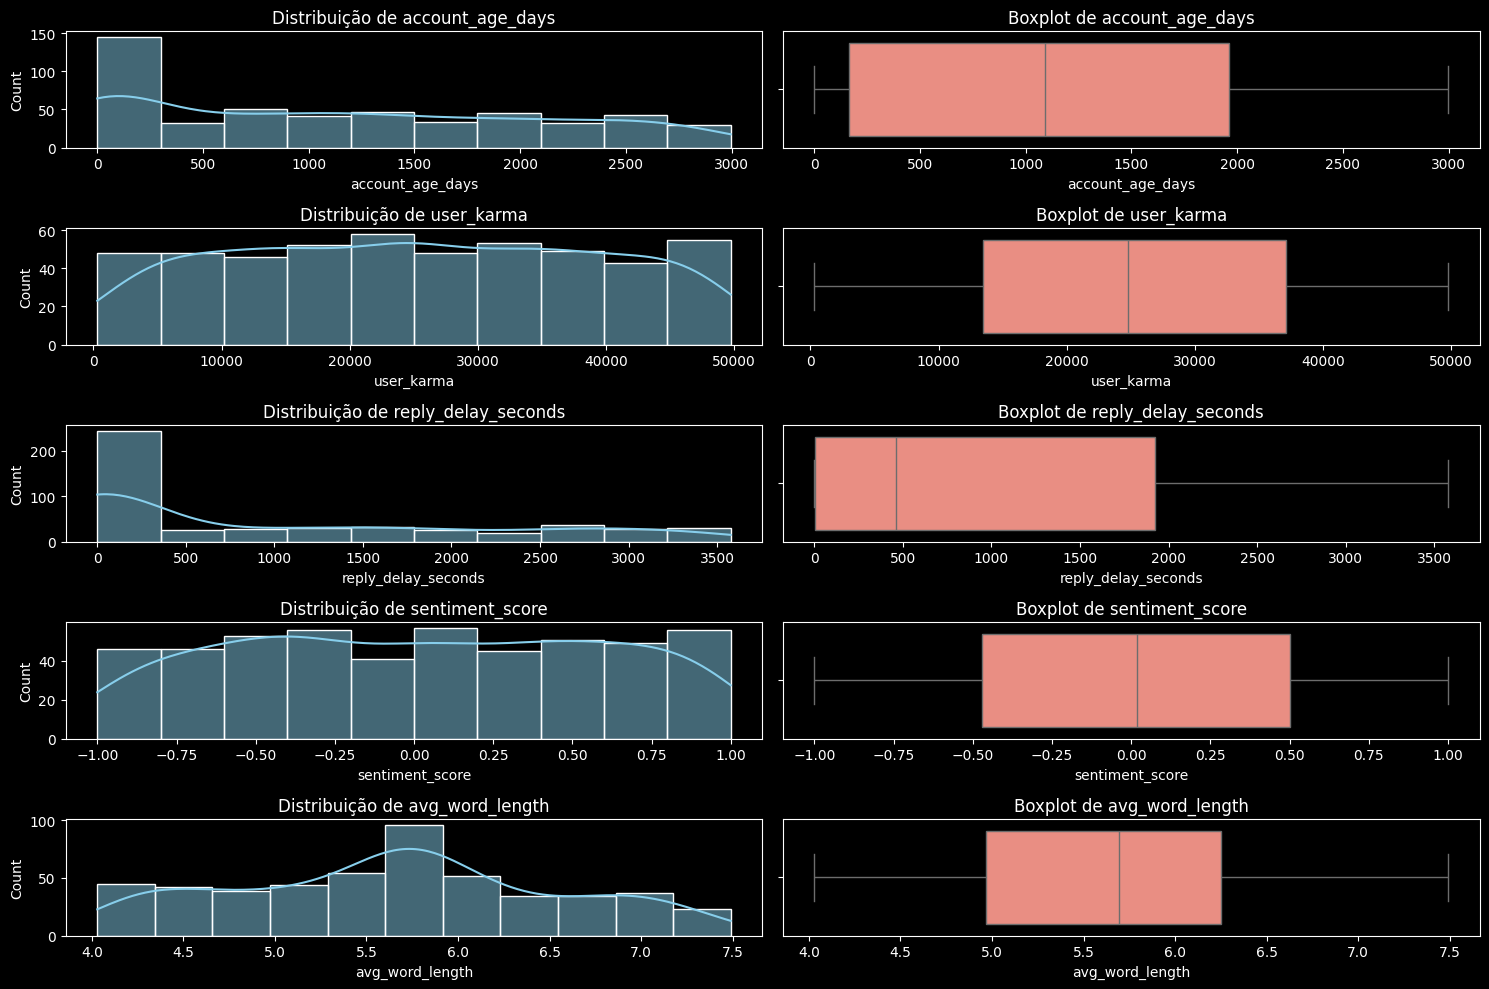

In [15]:
# Selecionando apenas as colunas numéricas relevantes
cols_numericas = ['account_age_days', 'user_karma', 'reply_delay_seconds',
                  'sentiment_score', 'avg_word_length']

# Configuração da figura
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(cols_numericas):
    # Plot de Distribuição
    plt.subplot(len(cols_numericas), 2, 2*i + 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribuição de {col}')

    # Plot de Boxplot (para ver Outliers)
    plt.subplot(len(cols_numericas), 2, 2*i + 2)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot de {col}')

    # Teste de Normalidade (Shapiro-Wilk)
    stat, p = shapiro(df[col].dropna())
    print(f'Variável: {col} | p-value: {p:.4f} | {"Normal" if p > 0.05 else "Não-Normal"}')

plt.tight_layout()
plt.savefig(fname='images/distribuicao_variaveis.png')
plt.show()

In [19]:
outliers_info = mapear_outliers(df[cols_numericas])

for col, info in outliers_info.items():
    print(f"contagem de outliers para {col}: {info['outlier_count']}")

contagem de outliers para account_age_days: 0
contagem de outliers para user_karma: 0
contagem de outliers para reply_delay_seconds: 0
contagem de outliers para sentiment_score: 0
contagem de outliers para avg_word_length: 0


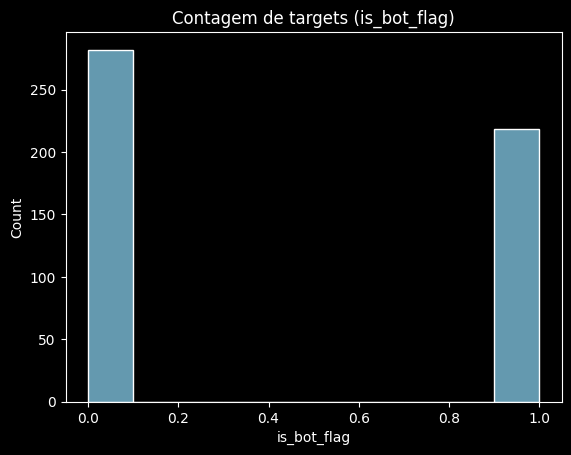

In [29]:
sns.histplot(df['is_bot_flag'], color='skyblue')
plt.title('Contagem de targets (is_bot_flag)')
plt.savefig(fname='images/distribuicao_is_bot_flag.png')
plt.show()

In [30]:
df['is_bot_flag'].value_counts()

is_bot_flag
False    282
True     218
Name: count, dtype: int64

## Pré-processamento
Observa-se que a base é balanceada, não possui outliers expressivos ou duplicatas. Portanto, o pré-processamento vai se resumir à análise da correlação e definição do column transformer (faremos testes com MinMax e StandardScaler para numéricos, OneHotEncoder para categóricos)

In [ ]:
cols_numericas.append('contains_links')
sns.heatmap(df[cols_numericas + ['is_bot_flag']].corr(), annot=True, cmap='coolwarm')

In [ ]:
X = df.drop(columns=['is_bot_flag'])
y = df['is_bot_flag']

col_transf_std = ColumnTransformer(
    [
        ('num', StandardScaler(), cols_numericas),
        ('cat', OneHotEncoder(drop='first'), cols_categoricas)
    ]
  )

col_transf_min_max = ColumnTransformer(
    [
        ('num', MinMaxScaler(), cols_numericas),
        ('cat', OneHotEncoder(drop='first'), cols_categoricas)
    ]
  )

## Treino e Teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=42)

knn_params = {
    'n_neighbors': [3, 9, 20, 100],
    'weights': ['uniform', 'distance']
}